Welcome to my attempt at the Intelinair CVPR challenge! The goal is to do semantic segmentation of the images provided. 

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ELU, Conv3D, ConvLSTM2D 
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import random
import cv2
import sys

In [195]:
input_img0_names = []
input_img1_names = []
input_img2_names = []
boundary_mask_names = []
nutrient_mask_names = []

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 1
src_dir = '/home/garrett/Documents/IntelinAirData/Longitudinal_Nutrient_Deficiency'

for i in range(1,387):
    filestring = str(i).zfill(3)
    input_img0_names.append(os.path.join(src_dir, f'field_{filestring}/image_i0.png'))
    input_img1_names.append(os.path.join(src_dir, f'field_{filestring}/image_i1.png'))
    input_img2_names.append(os.path.join(src_dir, f'field_{filestring}/image_i2.png'))
    boundary_mask_names.append(os.path.join(src_dir, f'field_{filestring}/bounday_mask.png'))
    nutrient_mask_names.append(os.path.join(src_dir, f'field_{filestring}/nutrient_mask_g0.png'))
    
df = pd.DataFrame({'image_0':input_img0_names , 'image_1':input_img1_names, 'image_2':input_img2_names, 
                   'boundary_mask':boundary_mask_names, 'nutrient_mask':nutrient_mask_names})
#df.reset_index(drop=True, inplace=True)
df.head(5)

XY_train,XY_valtest = train_test_split(df, train_size=0.8, random_state=0)
XY_val, XY_test = train_test_split(XY_valtest, train_size=0.5, random_state=0)
XY_train.reset_index(drop=True, inplace=True)
XY_val.reset_index(drop=True, inplace=True)
XY_test.reset_index(drop=True, inplace=True)
XY_train.head(5)

,image_0,image_1,image_2,boundary_mask,nutrient_mask
0,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
1,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
2,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
3,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
4,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...


(-0.5, 1260.5, 1107.5, -0.5)

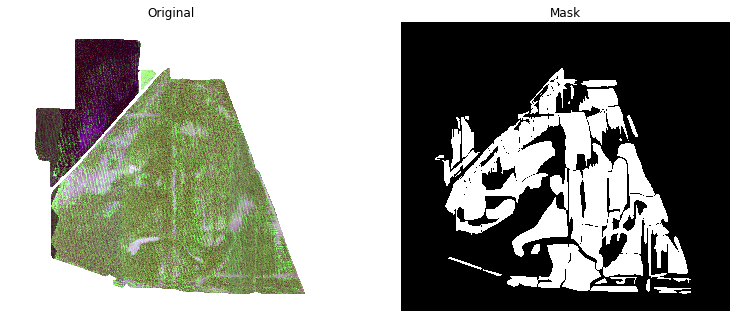

In [196]:
index = random.randint(0, len(XY_train)-1)
img = cv2.imread(XY_train.loc[index].at["image_0"])
mask = cv2.imread(XY_train.loc[index].at["nutrient_mask"])
npmask = np.array(mask)
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

In [197]:
def myGenerator(generator1,generator2,generator3,outgenerator):
        while True:
            for x0,x1,x2,y1 in zip(generator1,generator2,generator3,outgenerator):
                yield ([x0,x1,x2],y1[:,:,:,2])

In [198]:
image0_train_datagen = ImageDataGenerator(rescale=1./255.)
image1_train_datagen = ImageDataGenerator(rescale=1./255.)
image2_train_datagen = ImageDataGenerator(rescale=1./255.)
mask_train_datagen = ImageDataGenerator(rescale=1./255.)

image0_val_datagen = ImageDataGenerator(rescale=1./255.)
image1_val_datagen = ImageDataGenerator(rescale=1./255.)
image2_val_datagen = ImageDataGenerator(rescale=1./255.)
mask_val_datagen = ImageDataGenerator(rescale=1./255.)

In [199]:
seed = 1

image0_train_generator = image0_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_0",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image1_train_generator = image1_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_1",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image2_train_generator = image2_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_2",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

mask_train_generator = mask_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="nutrient_mask",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = myGenerator(image0_train_generator, image1_train_generator, image2_train_generator, mask_train_generator)

Found 308 validated image filenames.
Found 308 validated image filenames.
Found 308 validated image filenames.
Found 308 validated image filenames.


In [200]:
seed = 1

image0_val_generator = image0_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_0",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image1_val_generator = image1_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_1",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image2_val_generator = image2_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_2",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

mask_val_generator = mask_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="nutrient_mask",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

# combine generators into one which yields image and masks
val_generator = myGenerator(image0_val_generator, image1_val_generator, image2_val_generator, mask_val_generator)

Found 39 validated image filenames.
Found 39 validated image filenames.
Found 39 validated image filenames.
Found 39 validated image filenames.


In [201]:
#Given that I'm training three U-Nets in parallel, I can only afford a few filters for each layer.

def UNet(image_input):

    ''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    c1 = Conv2D(8, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(image_input)
    c1 = ELU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(8, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c1)
    c1 = ELU()(c1)
    c1 = BatchNormalization()(c1)
    
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(8*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p1)
    c2 = ELU()(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(8*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c2)
    c2 = ELU()(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)
    

    c3 = Conv2D(8*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p2)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(8*2, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(8*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)

    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(8*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p3)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(8*4, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(8*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)

    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(8*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p4)
    c5 = ELU()(c5)
    c5 = BatchNormalization()(c5)


    ''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    u1 = UpSampling2D((2,2))(c5)
    concat1 = Concatenate()([c4, u1])

    c6 = Conv2D(8*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat1)
    c6 = ELU()(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(8*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c6)
    c6 = ELU()(c6)
    c6 = BatchNormalization()(c6)


    u2 = UpSampling2D((2,2))(c6)
    concat2 = Concatenate()([c3, u2])

    c7 = Conv2D(8*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat2)
    c7 = ELU()(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(8*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c7)
    c7 = ELU()(c7)
    c7 = BatchNormalization()(c7)

    u3 = UpSampling2D((2,2))(c7)
    concat3 = Concatenate()([c2, u3])

    c8 = Conv2D(8, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat3)
    c8 = ELU()(c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(8, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c8)
    c8 = ELU()(c8)
    c8 = BatchNormalization()(c8)

    u4 = UpSampling2D((2,2))(c8)
    concat4 = Concatenate()([c1, u4])

    c9 = Conv2D(4, kernel_size = (1,1), kernel_initializer='he_normal', padding = 'same')(concat4)
    c9 = ELU()(c9)
    c9 = BatchNormalization()(c9)

    mask_out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding = 'same', activation = 'sigmoid')(c9)
    
    return mask_out

In [202]:
def ConvLSTM(movieIn):
    
    x = ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(movieIn)

    x = BatchNormalization()(x)

    x = ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(x)
    
    x = BatchNormalization()(x)
    
    x = ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(x)
    
    x = BatchNormalization()(x)
    
    lastmask = Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    activation="sigmoid",
    padding="same"
    )(x)
    
    return lastmask[:,2,:,:,:]

In [203]:
def FullModel():

    image0 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img0_input')
    image1 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img1_input')
    image2 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img2_input')

    X1= UNet(image0)
    X2= UNet(image1)
    X3= UNet(image2)

    
    X1 = tf.keras.backend.expand_dims(X1,axis=1)
    X2 = tf.keras.backend.expand_dims(X2,axis=1)
    X3 = tf.keras.backend.expand_dims(X3,axis=1)
    movie=Concatenate(axis=1)([X1, X2, X3])

    
    outmask = ConvLSTM(movie)
    model = Model(inputs = [image0,image1,image2], outputs = outmask, name='SemanticSegModel')

    
    return model

In [204]:
def lrfn(epoch):
    if epoch > 15:
        return 2e-4
    elif epoch > 25:
        return 1e-4
    return 1e-3

In [205]:
# Learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
# Model checkpoint, saves weights if val loss reduces
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', 'val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [206]:
opt_adam = optimizers.Adam()

model = FullModel()
model.compile(optimizer = opt_adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "SemanticSegModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img0_input (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
img1_input (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
img2_input (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_798 (Conv2D)             (None, 256, 256, 8)  224         img0_input[0][0]                 
___________________________________________________________________________________

In [208]:
train_steps = len(image0_train_generator)
val_steps = len(image0_val_generator)

history = model.fit(train_generator, validation_data=val_generator, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 30, verbose=1, callbacks=[checkpoint, lr_callback])





Epoch 1/30
308/308 [==============================] - 44s 144ms/step - loss: 51.0589 - accuracy: 0.9592 - val_loss: 46.9274 - val_accuracy: 0.9613

Epoch 00001: val_loss did not improve from 40.09563
Epoch 2/30
308/308 [==============================] - 46s 151ms/step - loss: 50.5768 - accuracy: 0.9594 - val_loss: 34.9525 - val_accuracy: 0.9710

Epoch 00002: val_loss improved from 40.09563 to 34.95251, saving model to model.h5
Epoch 3/30
308/308 [==============================] - 50s 162ms/step - loss: 50.5235 - accuracy: 0.9592 - val_loss: 43.0568 - val_accuracy: 0.9643

Epoch 00003: val_loss did not improve from 34.95251
Epoch 4/30
308/308 [==============================] - 50s 163ms/step - loss: 50.0259 - accuracy: 0.9595 - val_loss: 36.9382 - val_accuracy: 0.9699

Epoch 00004: val_loss did not improve from 34.95251
Epoch 5/30
308/308 [==============================] - 50s 161ms/step - loss: 50.2565 - accuracy: 0.9592 - val_loss: 42.0996 - val_accuracy: 0.9647

Epoch 00005: val_loss

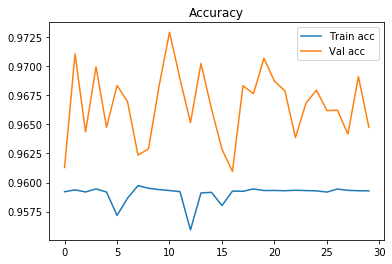

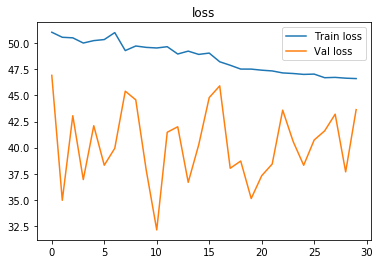

In [209]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Train acc')
plt.plot(history.history['val_accuracy'], label = 'Val acc')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('loss')
plt.legend()